<a href="https://colab.research.google.com/github/gustavolio/Privacy_Preserving_Heterogeneous_Network_Embedding/blob/main/Heterogeneos_network_with_synthea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download and unzip data

In [ ]:
!wget https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
!unzip synthea_sample_data_csv_apr2020
!mv csv/* .

--2021-03-05 00:39:32--  https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.2.112, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8982431 (8.6M) [application/zip]
Saving to: ‘synthea_sample_data_csv_apr2020.zip’

synthea_sample_data 100%[===================>]   8.57M  --.-KB/s    in 0.1s    

2021-03-05 00:39:32 (57.7 MB/s) - ‘synthea_sample_data_csv_apr2020.zip’ saved [8982431/8982431]

Archive:  synthea_sample_data_csv_apr2020.zip
   creating: csv/
  inflating: csv/medications.csv     
  inflating: csv/providers.csv       
  inflating: csv/payer_transitions.csv  
  inflating: csv/imaging_studies.csv  
  inflating: csv/supplies.csv        
  inflating: csv/payers.csv          
  inflating: csv/allergies.csv       
  inflating: csv/procedures.csv  

In [ ]:
#Remove unnecessary files
!rm -r /content/payers.csv
!rm -r /content/providers.csv
!rm -r /content/organizations.csv
!rm -r /content/supplies.csv
!rm -r /content/payer_transitions.csv

## Read csv files

In [ ]:
#Read files and create and array with all of them
import numpy as np
import pandas as pd
import glob
import networkx as nx
import matplotlib.pyplot as plt
import re
import datetime
from dateutil.relativedelta import relativedelta

#Read all csv files
def read_csv(file_names, path):
    data = []

    for filename in file_names:
        file_path = path + filename;
        df = pd.read_csv(file_path, header=0)
        #dropnan
        data.append(df)

    return data
    
def print_file_index(file_names, data):
    for index,df in enumerate(syn_data):
        print("{} -- index:{}".format(df_file_names[index], index))

df_file_names = glob.glob("*.csv")
syn_data = read_csv(df_file_names, '/content/')
print_file_index(df_file_names, syn_data)

observations.csv -- index:0
encounters.csv -- index:1
immunizations.csv -- index:2
allergies.csv -- index:3
devices.csv -- index:4
conditions.csv -- index:5
careplans.csv -- index:6
procedures.csv -- index:7
imaging_studies.csv -- index:8
medications.csv -- index:9
patients.csv -- index:10


In [ ]:
def set_node_type(file_name, df):
    #get node type
    node_type = re.split("[.]", file_name)[0]
    #get number rows
    number_rows = df.shape[0]
    #create a new column with node type
    df['node_type'] = np.full(number_rows, node_type)

#Put node_type columns
for index,df in enumerate(syn_data):
    #get file name
    file_name = df_file_names[index]
    set_node_type(file_name, df)

#Print Node Types
for index,df in enumerate(syn_data):
    print(df[:1]['node_type'].values)

['observations']
['encounters']
['immunizations']
['allergies']
['devices']
['conditions']
['careplans']
['procedures']
['imaging_studies']
['medications']
['patients']


## Create Network

In [ ]:
# child =< 12
# 12 < young < 18
# 18 <= adult < 60
# 60 <= elderly
def set_age_cat(birthdate, deathdate):
    category = ''
    age = 0
    final_date = datetime.datetime.now()
    birth = datetime.datetime(int(birthdate[0:4]),int(birthdate[5:7]),int(birthdate[8:]))

    if not(pd.isnull(deathdate)):
        final_date = datetime.datetime(int(deathdate[0:4]),int(deathdate[5:7]),int(deathdate[8:]))

    age = relativedelta(final_date, birth).years
    if (age <= 12):
        category = 'child'
    elif (12 < age < 18):
        category = 'young'
    elif (18 <= age < 60):
        category = 'adult'
    else:
        category = 'eaderly'

    return category

#Add generic nodes
def add_syn_node(graph, df):
    for index,n_data in df.iterrows():
        graph.add_node(n_data['DESCRIPTION'], node_type=n_data['node_type'])
        graph.add_edge(n_data['PATIENT'], n_data['DESCRIPTION'])

#Add imaging_studies nodes
def add_syn_node_img(graph, df):
    for index,n_data in df.iterrows():
        graph.add_node(n_data['BODYSITE_DESCRIPTION'], node_type=n_data['node_type'])
        graph.add_edge(n_data['PATIENT'], n_data['BODYSITE_DESCRIPTION'])

#Add patients node nodes
def add_syn_node_pat(graph, df):
    for index,n_data in df.iterrows():
        age_cat = set_age_cat(n_data['BIRTHDATE'], n_data['DEATHDATE'])

        graph.add_node(n_data['Id'],
                       node_type=n_data['node_type'],ethnicity=n_data['ETHNICITY'],
                       birth=n_data['BIRTHDATE'], death=n_data['DEATHDATE'],
                       gender=n_data['GENDER'], age_category=age_cat,
                       marital=n_data['MARITAL'], race=n_data['RACE'],
                       city=n_data['CITY'])


G = nx.Graph()
#Create a heterogeneous network
for index,df in enumerate(syn_data):
    node_type = df[:1]['node_type'].values[0]

    if node_type == 'patients':
        add_syn_node_pat(G, df)
    elif node_type == 'imaging_studies':
        add_syn_node_img(G, df)
    else:
        add_syn_node(G, df)
    
    print('{}/{} -- {}'.format(index, len(syn_data), node_type))

0/11 -- observations
1/11 -- encounters
2/11 -- immunizations
3/11 -- allergies
4/11 -- devices
5/11 -- conditions
6/11 -- careplans
7/11 -- procedures
8/11 -- imaging_studies
9/11 -- medications
10/11 -- patients


In [ ]:
# number of nodes
print("Number of Node: {} \nNumber of Edges: {}".format(len(G), G.number_of_edges()))


Number of Node: 1834 
Number of Edges: 78055


# Heterogeneous Network Regularization

In [ ]:
!pip install git+https://github.com/rmarcacini/sentence-transformers
!pip install gdown
!gdown https://drive.google.com/uc?id=1NV5t1YhyyOzMF5zAovfbSLdZZLvqrfZ_
!unzip distiluse-base-multilingual-cased.zip -d language_model
from sentence_transformers import SentenceTransformer, LoggingHandler
import numpy as np
import logging

np.set_printoptions(threshold=100)
logging.basicConfig(format='%(asctime)s - %(message)s',datefmt='%Y-%m-%d %H:%M:%S',level=logging.INFO,handlers=[LoggingHandler()])

language_model = SentenceTransformer('./language_model')

  Cloning https://github.com/rmarcacini/sentence-transformers to /tmp/pip-req-build-ov4gv0zc
  Running command git clone -q https://github.com/rmarcacini/sentence-transformers /tmp/pip-req-build-ov4gv0zc
     |████████████████████████████████| 890kB 13.2MB/s 
     |████████████████████████████████| 3.0MB 29.7MB/s 
     |████████████████████████████████| 1.2MB 53.7MB/s 
     |████████████████████████████████| 890kB 54.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp37-none-any.whl size=101874 sha256=ba8caae98007c5b95271584fa30ab4b17e803a09f024aea9bc3eec8f87a1f956
  Stored in directory: /tmp/pip-ephem-wheel-cache-rxs909ir/wheels/88/3c/66/55ee9fb698480d5a5116a8257c15dc363323e4922fb8ad361b
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d945f209bdf76162f348f61d67d5176fbc98a682f56af67b678c0077f5d5138f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58

In [ ]:
## Add y attr at node. y represents a embedding.
from tqdm.notebook import tqdm
counter = 0
cache_embedding = {}
for node in tqdm(G.nodes()):
  if 'node_type' not in G.nodes[node]:
    print('Erro com o node: ',node,' esta sem node type??')
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']!='patients':
    embedding = None
    if node not in cache_embedding:
      embedding = language_model.encode(node,show_progress_bar=False)
      cache_embedding[node]=embedding
    else:
      embedding = cache_embedding[node]
    G.nodes[node]['y'] = embedding

In [ ]:
for node in tqdm(G.nodes(data=True)):
  if 'node_type' in G.nodes[node[0]] and G.nodes[node[0]]['node_type']!='patients':
    print(node)

('Encounter for symptom', {'node_type': 'encounters', 'y': array([ 0.02969579, -0.02473867, -0.02566442, ..., -0.03097034,
       -0.0297178 , -0.01803867], dtype=float32)})
('General examination of patient (procedure)', {'node_type': 'encounters', 'y': array([-0.00467251,  0.07583341, -0.03105897, ...,  0.04695197,
       -0.03019542,  0.0636064 ], dtype=float32)})
('Consultation for treatment', {'node_type': 'encounters', 'y': array([-0.05861691, -0.02284353, -0.02149131, ...,  0.04682655,
        0.02606536,  0.08397853], dtype=float32)})
('Well child visit (procedure)', {'node_type': 'encounters', 'y': array([-0.04769498,  0.00681473, -0.02597801, ...,  0.01665607,
       -0.03313167, -0.04380436], dtype=float32)})
('Encounter for check up (procedure)', {'node_type': 'encounters', 'y': array([-0.01131966, -0.00208724, -0.01989651, ..., -0.003456  ,
       -0.08089617, -0.00894672], dtype=float32)})
('Urgent care clinic (procedure)', {'node_type': 'encounters', 'y': array([-0.084564

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random


def regularization(G, dim, iterations=15, mi=0.85):

    nodes = []

    # inicializando vetor f para todos os nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if 'y' in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node]['y']*1.0
        nodes.append(node)

    pbar = tqdm(range(0, iterations))

    for iteration in pbar:
        random.shuffle(nodes)
        energy = 0.0

        # percorrendo cada node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0

            # percorrendo vizinhos do node
            for neighbor in G.neighbors(node):
                w = 1.0
                if 'weight' in G[node][neighbor]:
                    w = G[node][neighbor]['weight']

                w /= np.sqrt(G.degree[neighbor])

                f_new += w*G.nodes[neighbor]['f']

                sum_w += w

            if sum_w == 0: continue
            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if 'y' in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node]['y'] * mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)

        iteration += 1
        message = 'Iteration '+str(iteration)+' | Energy = '+str(energy)
        pbar.set_description(message)

    return G

regularization(G,512)

In [ ]:
for node in tqdm(G.nodes(data=True)):
  if 'node_type' in G.nodes[node[0]] and G.nodes[node[0]]['node_type']=='patients':
    print(node)

('034e9e3b-2def-4559-bb2a-7850888ae060', {'node_type': 'patients', 'ethnicity': 'nonhispanic', 'birth': '1983-11-14', 'death': nan, 'gender': 'M', 'age_category': 'adult', 'marital': 'M', 'race': 'white', 'city': 'Somerville', 'f': array([ 0.00443441,  0.00654969, -0.02690506, ..., -0.02490252,
       -0.01039342, -0.00025948])})
('1d604da9-9a81-4ba9-80c2-de3375d59b40', {'node_type': 'patients', 'ethnicity': 'hispanic', 'birth': '1989-05-25', 'death': nan, 'gender': 'M', 'age_category': 'adult', 'marital': 'M', 'race': 'white', 'city': 'Chicopee', 'f': array([ 0.01063827,  0.00905324, -0.02226965, ..., -0.02161697,
       -0.00474547, -0.00510623])})
('10339b10-3cd1-4ac3-ac13-ec26728cb592', {'node_type': 'patients', 'ethnicity': 'nonhispanic', 'birth': '1992-06-02', 'death': nan, 'gender': 'M', 'age_category': 'adult', 'marital': 'M', 'race': 'white', 'city': 'Chicopee', 'f': array([ 0.00520518,  0.01371602, -0.02535937, ..., -0.01338876,
       -0.01464601,  0.00092697])})
('8d4c4326-

# Convesions for algorithm input

In [ ]:
node_list = [] # garantir sempre na mesma ordem
for node in G.nodes():
  #if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
    node_list.append(node)

In [ ]:
#Adjacence matrix
adj_matrix = nx.adjacency_matrix(G,nodelist=node_list)
adj_matrix.todense().shape

(1834, 1834)

In [ ]:
# Feature matrix

## Escolhi o node Prediabetes como utility feature / label
utility_feature = []
utility_label = []
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
    for node2 in G.nodes():
      if 'node_type' in G.nodes[node2] and G.nodes[node2]['node_type']=='conditions' and node2 == 'Prediabetes':
            if node in G.neighbors(node2):
              print(node,node2,'y')
              utility_feature.append([0,1,0]) # one-hot
              utility_label.append([1])
              break
            else:
              print(node,node2,'n')
              utility_feature.append([0,0,1]) # one-hot
              utility_label.append([2])
              break
  else: # caso nao seja node de paciente
    print(node,'none')
    utility_feature.append([1,0,0]) # one-hot
    utility_label.append([0])


# # Escolhi o node Otitis media como utility feature / label
# utility_feature = []
# utility_label = []
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
#     for node2 in G.nodes():
#       if 'node_type' in G.nodes[node2] and G.nodes[node2]['node_type']=='conditions' and node2 == 'Otitis media':
#             if node in G.neighbors(node2):
#               print(node,node2,'y')
#               utility_feature.append([0,1,0]) # one-hot
#               utility_label.append([1])
#               break
#             else:
#               print(node,node2,'n')
#               utility_feature.append([0,0,1]) # one-hot
#               utility_label.append([2])
#               break
#   else: # caso nao seja node de paciente
#     print(node,'none')
#     utility_feature.append([1,0,0]) # one-hot
#     utility_label.append([0])
    

Encounter for symptom none
034e9e3b-2def-4559-bb2a-7850888ae060 Prediabetes n
General examination of patient (procedure) none
1d604da9-9a81-4ba9-80c2-de3375d59b40 Prediabetes n
10339b10-3cd1-4ac3-ac13-ec26728cb592 Prediabetes n
Consultation for treatment none
8d4c4326-e9de-4f45-9a4c-f8c36bff89ae Prediabetes n
Well child visit (procedure) none
f5dcd418-09fe-4a2f-baa0-3da800bd8c3a Prediabetes n
Encounter for check up (procedure) none
Urgent care clinic (procedure) none
Patient encounter procedure none
Emergency room admission (procedure) none
72c0b9ce-7aa4-430b-aaff-bd0ce7846e55 Prediabetes n
b1e9b0b9-da6e-4f68-b603-bd896a50ca86 Prediabetes n
01207ecd-9dff-4754-8887-4652eda231e2 Prediabetes n
b58731cc-2d8b-4c2d-b327-4cab771af3ef Prediabetes n
Encounter for 'check-up' none
Encounter Inpatient none
Prenatal initial visit none
Prenatal visit none
Obstetric emergency hospital admission none
Postnatal visit none
cfee79fc-df05-476e-b274-43e09ea345db Prediabetes n
ad2e9916-4979-40fc-a8c0-68651a

In [ ]:
## Escolhi o node gender como privacy feature / label
privacy_feature = []
privacy_label = []
t = set()
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':      
    if G.nodes[node]['gender']=='F':
      privacy_feature.append([0,1,0]) #one-hot
      privacy_label.append([1])
      print(node,'gender','F')
    if G.nodes[node]['gender']=='M':
      privacy_feature.append([0,0,1]) #one-hot
      privacy_label.append([2])
      print(node,'gender','M')
  else: # caso nao seja node de paciente
    print(node,'gender','None')
    privacy_feature.append([1,0,0]) #one-hot
    privacy_label.append([0])


# ## Escolhi o node marital como privacy feature / label
# privacy_feature = []
# privacy_label = []
# t = set()
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':      
#     if G.nodes[node]['marital']: print(G.nodes[node]['marital'])
#     if G.nodes[node]['marital']=='S':
#       privacy_feature.append([0,1,0,0]) #one-hot
#       privacy_label.append([1])
#       print(node,'marital','S')
#     else:
#       if G.nodes[node]['marital']=='M':
#         privacy_feature.append([0,0,1,0]) #one-hot
#         privacy_label.append([2])
#         print(node,'marital','M')
#       else:
#         privacy_feature.append([0,0,0,1]) #one-hot
#         privacy_label.append([3])
#         print(node,'marital','O')
#   else: # caso nao seja node de paciente
#     #print(node,'gender','None')
#     privacy_feature.append([1,0,0,0]) #one-hot
#     privacy_label.append([0])

Encounter for symptom gender None
034e9e3b-2def-4559-bb2a-7850888ae060 gender M
General examination of patient (procedure) gender None
1d604da9-9a81-4ba9-80c2-de3375d59b40 gender M
10339b10-3cd1-4ac3-ac13-ec26728cb592 gender M
Consultation for treatment gender None
8d4c4326-e9de-4f45-9a4c-f8c36bff89ae gender F
Well child visit (procedure) gender None
f5dcd418-09fe-4a2f-baa0-3da800bd8c3a gender M
Encounter for check up (procedure) gender None
Urgent care clinic (procedure) gender None
Patient encounter procedure gender None
Emergency room admission (procedure) gender None
72c0b9ce-7aa4-430b-aaff-bd0ce7846e55 gender M
b1e9b0b9-da6e-4f68-b603-bd896a50ca86 gender F
01207ecd-9dff-4754-8887-4652eda231e2 gender F
b58731cc-2d8b-4c2d-b327-4cab771af3ef gender F
Encounter for 'check-up' gender None
Encounter Inpatient gender None
Prenatal initial visit gender None
Prenatal visit gender None
Obstetric emergency hospital admission gender None
Postnatal visit gender None
cfee79fc-df05-476e-b274-43e0

In [ ]:
print(np.array(utility_feature))
print(np.array(utility_label))
print(np.array(privacy_feature))
print(np.array(privacy_label))

[[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]
[[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
### generating feature matrix
feature_matrix = []
for patient in node_list:
  feature_matrix.append(G.nodes[patient]['f'])

feature_matrix = np.array(feature_matrix)
print(feature_matrix.shape)
feature_matrix

(1834, 512)


array([[ 0.02639083, -0.01876742, -0.02460548, ..., -0.02802045,
        -0.02604422, -0.01550512],
       [ 0.00443441,  0.00654969, -0.02690506, ..., -0.02490252,
        -0.01039342, -0.00025948],
       [-0.00294938,  0.06672984, -0.02931738, ...,  0.0384625 ,
        -0.0265105 ,  0.05393402],
       ...,
       [ 0.04605858,  0.03894666,  0.01561884, ..., -0.00187353,
        -0.04618961,  0.0039532 ],
       [ 0.03592697,  0.04197928, -0.00687157, ...,  0.06200592,
         0.01473839, -0.02683206],
       [ 0.03714005,  0.03723873, -0.02365765, ...,  0.05874996,
         0.01352241, -0.03870636]])

In [ ]:
### concatenando privacy features

feature_matrix = np.concatenate((feature_matrix,np.array(privacy_feature)), axis=1)
print(feature_matrix.shape)
feature_matrix

(1834, 515)


array([[ 0.02639083, -0.01876742, -0.02460548, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.00443441,  0.00654969, -0.02690506, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00294938,  0.06672984, -0.02931738, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04605858,  0.03894666,  0.01561884, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.03592697,  0.04197928, -0.00687157, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.03714005,  0.03723873, -0.02365765, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
### gerando label matrix (acho que essa parte eh desnecessaria)

label_matrix = np.concatenate((np.array(utility_label),np.array(privacy_label)),axis=1)
print(label_matrix.shape)
label_matrix

(1834, 2)


array([[0, 0],
       [2, 2],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

# Avaliando capacidade da representação textual em prever a utility feature

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier



emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(utility_feature[counter]))
    emb_patients.append(G.nodes[node]['f'])
  counter += 1

print(np.array(emb_patients).shape)
print(np.array(emb_labels).shape,np.min(np.array(emb_labels)),np.max(np.array(emb_labels)))



from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



(1171, 512)
(1171,) 1 2
0.83 f-1 macro with a standard deviation of 0.03
0.87 accuracy with a standard deviation of 0.02
[dummy] 0.52 f-1 macro with a standard deviation of 0.02
[dummy] 0.60 accuracy with a standard deviation of 0.02


2021-03-03 16:25:50 - NumExpr defaulting to 2 threads.


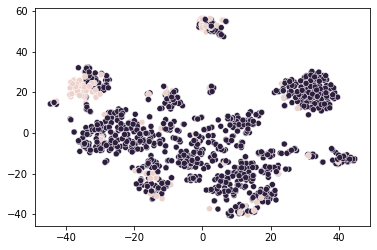

In [ ]:
import pandas as pd


import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('node2vec.pdf')

# Avaliando capacidade da representação textual em prever a privacy feature

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(privacy_feature[counter]))
    emb_patients.append(G.nodes[node]['f'])
  counter += 1

print(np.array(emb_patients).shape)
print(np.array(emb_labels).shape,np.min(np.array(emb_labels)),np.max(np.array(emb_labels)))

from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Privacy (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Privacy (NullModel-Mostfrequent)',dummy_clf.score(X_train,y_train))

# dummy_clf = DummyClassifier(strategy="stratified")
# dummy_clf.fit(X_train, y_train)
# print('Privacy (NullModel-stratified)',dummy_clf.score(X_train,y_train))

(1171, 512)
(1171,) 1 2
0.70 f-1 macro with a standard deviation of 0.02
0.70 accuracy with a standard deviation of 0.02
[dummy] 0.53 f-1 macro with a standard deviation of 0.05
[dummy] 0.51 accuracy with a standard deviation of 0.03


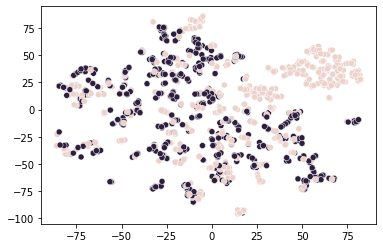

In [ ]:
import pandas as pd


import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=5).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('knn_hm_private.pdf')

 # Instanciando network embedding

In [ ]:
!git clone https://github.com/KaiyangLi1992/Privacy-Preserving-Social-Network-Embedding/

Cloning into 'Privacy-Preserving-Social-Network-Embedding'...
remote: Enumerating objects: 335, done.
remote: Total 335 (delta 0), reused 0 (delta 0), pack-reused 335
Receiving objects: 100% (335/335), 11.71 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
!mv Privacy-Preserving-Social-Network-Embedding/* .

In [ ]:
### enxugando o código apenas para treinar


from __future__ import division
from __future__ import print_function

import sys
import pickle as pkl
import tensorflow.compat.v1 as tf
import numpy as np
import scipy.sparse as sp
from input_data import load_data
from meansuring import get_score
from preprocessing import preprocess_graph,sparse_to_tuple,construct_feed_dict
from constructor import get_placeholder, get_model, get_optimizer, update
from process_attr import get_attr_list
# Train on CPU (hide GPU) due to memory constraints
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


tf.reset_default_graph()

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
# Settings
flags.DEFINE_string('f', '', 'Kernel')
flags.DEFINE_string('dataset', 'yale', 'Name of dateset')
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_float('discriminator_learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('hidden1', 128, 'Number of units in GCN layer 1.')
flags.DEFINE_integer('hidden3', 32, 'Number of units in discriminator layer 1.')
flags.DEFINE_integer('hidden4', 16, 'Number of units in discriminator layer 2.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')
flags.DEFINE_integer('epochs', 100, 'Number of iterations.')
flags.DEFINE_integer('pri_weight', 1,'weight of privacy')
flags.DEFINE_integer('uti_attr_weight', 1,'weight of utility_attr')
flags.DEFINE_integer('hidden2', 8, 'Number of units in GCN layer 2.')
flags.DEFINE_float('link_weight', 1,'weight of privacy')


# Load data
###adj, features, adj_train, val_edges, val_edges_false, test_edges, test_edges_false,labels = load_data(FLAGS.dataset)
#trocando pelas nossas variaveis
adj = adj_matrix
adj_train = adj_matrix
features = feature_matrix
labels = label_matrix



# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()


adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)
features_mat = features


######## trocando por
#attr_labels_list,dim_attr,features_rm_privacy = get_attr_list(FLAGS.dataset,labels,features_mat)

y=labels[:,0]
labels
# attr_labels = np.eye(len(np.unique(y)))[y.astype(int)-1]
# attr_labels = attr_labels [:,1:]
# attr_labels



attr_labels = np.array(utility_feature)

# y=labels[:,-1]
# privacy_labels = np.eye(len(np.unique(y)))[y.astype(int)-1]
# privacy_labels = privacy_labels [:,1:]
privacy_labels = np.array(privacy_feature)
privacy_labels

attr_labels_list = [attr_labels,privacy_labels]
attr_labels_list
dim_attr = [attr_labels.shape[1], privacy_labels.shape[1]]
dim_attr
features_rm_privacy = features_mat[:,:-np.array(privacy_feature).shape[1]] ## sem as privacy features
features_rm_privacy
# print(features_mat.shape)
# print(features_rm_privacy.shape)
# # ########

features_lil = sp.lil_matrix(features_rm_privacy)
#print('features_lil',features_lil)
features_tuple = sparse_to_tuple(features_lil .tocoo())
num_nodes = adj.shape[0]
features_sp = sparse_to_tuple(features_lil.tocoo())
num_features = features_sp[2][1]
features_nonzero = features_sp[1].shape[0]


pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = 1
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)


# # Define placeholders
print('a',attr_labels_list[-1])
print('b',attr_labels_list)
placeholders = get_placeholder(adj)
d_real, discriminator, ae_model = get_model(placeholders, num_features, 
                                            num_nodes, features_nonzero,attr_labels_list[-1],dim_attr)
opt = get_optimizer(ae_model, discriminator, placeholders, pos_weight, norm, d_real, 
                            num_nodes,attr_labels_list)


#train model
preds_all = None
labels_all = None
epochs = 10
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    emb,emb_long,avg_cost,attr_loss,pri_loss,link_loss = update(ae_model, opt, sess,adj_norm,adj_label,features_tuple, placeholders, adj)
    print(epoch,attr_loss,pri_loss,link_loss,avg_cost)

print("Optimization Finished!")

a [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
b [array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]]), array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


0 0.15428986 0.14440249 1.5050547 1.5081193
1 0.14204471 0.13602735 1.4419377 1.4493086
2 0.13435921 0.13196756 1.4249753 1.4255478
3 0.12850097 0.1348035 1.4087348 1.4021037
4 0.12355883 0.1389529 1.3892348 1.3733683
5 0.11811649 0.13729273 1.386348 1.3603541
6 0.11544502 0.14417014 1.3679498 1.3422611
7 0.11151505 0.14626653 1.3652321 1.3269101
8 0.10715728 0.14414582 1.3603774 1.3237774
9 0.104388274 0.15017503 1.3596134 1.3153956
Optimization Finished!


In [ ]:
emb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
pd.DataFrame(emb)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.481980,0.0,0.0,0.0,0.663846,0.0,0.421756,0.0,0.0,0.635643,0.0,0.0,0.0,0.000000,0.326006,0.0,0.482587,0.433751,0.626146,0.0,0.034770,0.0,0.0,0.430560,0.215631,0.0,0.0,0.498625,0.0,0.437488,0.651577,0.0,0.0,0.559959,0.000000,0.531424,0.0,0.0,0.0,0.0,0.0,0.231299,0.0,0.114473,0.0,0.696105,0.540560,0.0,0.000000,0.0,0.581321,0.0,0.431821,0.0,0.344370,0.0,0.338291,0.0,0.686800,0.187379,0.0,0.391202,0.0,0.0
1,0.015586,0.0,0.0,0.0,0.062520,0.0,0.005688,0.0,0.0,0.058810,0.0,0.0,0.0,0.000000,0.014190,0.0,0.020145,0.006275,0.079267,0.0,0.000000,0.0,0.0,0.049588,0.000000,0.0,0.0,0.034557,0.0,0.052350,0.081138,0.0,0.0,0.038527,0.000000,0.054570,0.0,0.0,0.0,0.0,0.0,0.004757,0.0,0.000000,0.0,0.053775,0.000000,0.0,0.000000,0.0,0.019564,0.0,0.023470,0.0,0.045330,0.0,0.027580,0.0,0.043727,0.000000,0.0,0.000122,0.0,0.0
2,0.468773,0.0,0.0,0.0,0.652358,0.0,0.419781,0.0,0.0,0.632100,0.0,0.0,0.0,0.000000,0.326253,0.0,0.477699,0.434574,0.622077,0.0,0.035435,0.0,0.0,0.428918,0.209758,0.0,0.0,0.496772,0.0,0.420730,0.653727,0.0,0.0,0.552354,0.000000,0.531023,0.0,0.0,0.0,0.0,0.0,0.225001,0.0,0.109399,0.0,0.693069,0.540101,0.0,0.000000,0.0,0.579576,0.0,0.426255,0.0,0.342554,0.0,0.337454,0.0,0.688020,0.181292,0.0,0.387579,0.0,0.0
3,0.009017,0.0,0.0,0.0,0.048374,0.0,0.000000,0.0,0.0,0.038923,0.0,0.0,0.0,0.000000,0.000000,0.0,0.008380,0.000000,0.058842,0.0,0.000000,0.0,0.0,0.034952,0.000000,0.0,0.0,0.020485,0.0,0.050941,0.061960,0.0,0.0,0.024651,0.000000,0.039925,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.033007,0.000000,0.0,0.000000,0.0,0.001008,0.0,0.007870,0.0,0.035829,0.0,0.014024,0.0,0.021990,0.000000,0.0,0.000000,0.0,0.0
4,0.028270,0.0,0.0,0.0,0.077058,0.0,0.015823,0.0,0.0,0.072631,0.0,0.0,0.0,0.000000,0.021418,0.0,0.030676,0.017046,0.093453,0.0,0.000000,0.0,0.0,0.058285,0.000000,0.0,0.0,0.045733,0.0,0.063643,0.093003,0.0,0.0,0.052201,0.000000,0.066859,0.0,0.0,0.0,0.0,0.0,0.011824,0.0,0.000000,0.0,0.070128,0.009705,0.0,0.000000,0.0,0.032503,0.0,0.034091,0.0,0.051741,0.0,0.035972,0.0,0.059218,0.000000,0.0,0.009762,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.001972,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1830,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1831,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1832,0.000000,0.0,0.0,0.0,0.010125,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.015771,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.022756,0.032234,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0

# Avaliando a capacidade da embedding gerada em prever a utility

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(utility_feature[counter]))
    emb_patients.append(emb[counter])
  counter += 1


from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42,class_weight={1: 4})
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)
# clf = make_pipeline(StandardScaler(), SVC(random_state=42,class_weight={1: 8}))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))
# print(clf.predict(X_test),np.array(clf.predict(X_test)).min())
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Utility (NullModel)',dummy_clf.score(X_train,y_train))

0.72 f-1 macro with a standard deviation of 0.02
0.77 accuracy with a standard deviation of 0.02
[dummy] 0.52 f-1 macro with a standard deviation of 0.03
[dummy] 0.63 accuracy with a standard deviation of 0.03


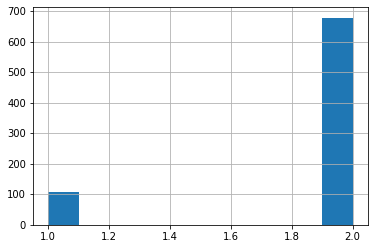

In [ ]:
pd.DataFrame(y_train)[0].hist()

# Avaliando a capacidade da embedding gerada em prever a privacy

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(privacy_feature[counter]))
    emb_patients.append(emb[counter])
  counter += 1



from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.66 f-1 macro with a standard deviation of 0.02
0.66 accuracy with a standard deviation of 0.02
[dummy] 0.49 f-1 macro with a standard deviation of 0.02
[dummy] 0.49 accuracy with a standard deviation of 0.03


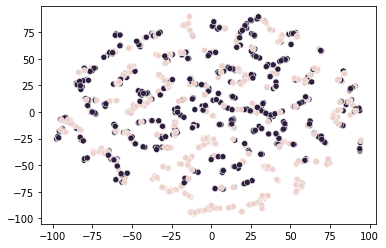

In [ ]:
import pandas as pd


import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=3).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('approach_private.pdf')

# Comparar contra algum método de Graph Embedding sem controle de privacidade

In [ ]:
# todo... 
# idealmente usar o GAE (graph-autoencoder) conforme paper base...
# por hora, usar o node2vec
# em geral, node2vec consegue preservar muito bem... mas nao tem suporte a controle de privacidade

In [ ]:
# !pip install node2vec

In [ ]:
# import networkx as nx
# from node2vec import Node2Vec


# # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
# node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=30, workers=4)  # Use temp_folder for big graphs

# # Embed nodes
# model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)


### Prevendo utility via node2vec

In [ ]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.dummy import DummyClassifier

# emb_labels = []
# emb_patients = []
# counter = 0
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
#     emb_labels.append(np.argmax(utility_feature[counter]))
#     emb_patients.append(model[node]) # embeddings do node2vec
#   counter += 1

# print(np.array(emb_patients).shape)
# print(np.array(emb_labels).shape,np.min(np.array(emb_labels)),np.max(np.array(emb_labels)))

# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Utility (NullModel)',dummy_clf.score(X_train,y_train))

### Prevendo privacy via node2vec

In [ ]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.dummy import DummyClassifier

# emb_labels = []
# emb_patients = []
# counter = 0
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
#     emb_labels.append(np.argmax(privacy_feature[counter]))
#     emb_patients.append(model[node]) # embeddings do node2vec
#   counter += 1

# print(np.array(emb_patients).shape)
# print(np.array(emb_labels).shape,np.min(np.array(emb_labels)),np.max(np.array(emb_labels)))

# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Privacy (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Privacy (NullModel)',dummy_clf.score(X_train,y_train))

# Comparar contra algum método de Graph Embedding + CDSPIA

 CDSPIA [28] is a stateof-the-art approach to defending inference attacks on graph by deleting or perturbing users’ attributes and linkages which
are closely related to privacy. We use CDSPIA to sanitize the
graph dataset and then embed the graph data processed.

In [ ]:
# todo...

In [ ]:
!git clone https://github.com/tkipf/gae

Cloning into 'gae'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [ ]:
!cd gae; python setup.py install

running install
running bdist_egg
running egg_info
creating gae.egg-info
writing gae.egg-info/PKG-INFO
writing dependency_links to gae.egg-info/dependency_links.txt
writing requirements to gae.egg-info/requires.txt
writing top-level names to gae.egg-info/top_level.txt
writing manifest file 'gae.egg-info/SOURCES.txt'
writing manifest file 'gae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/gae
copying gae/initializations.py -> build/lib/gae
copying gae/preprocessing.py -> build/lib/gae
copying gae/optimizer.py -> build/lib/gae
copying gae/train.py -> build/lib/gae
copying gae/__init__.py -> build/lib/gae
copying gae/model.py -> build/lib/gae
copying gae/input_data.py -> build/lib/gae
copying gae/layers.py -> build/lib/gae
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/gae
copying build/lib/gae/initializati

In [ ]:
!mv gae gae_pkg; mv gae_pkg/gae .

In [ ]:
tf.reset_default_graph()
del sys.modules["tensorflow"]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term
2021-03-03 15:22:08 - From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
L = []
for a in sys.modules:
  if 'gae.' in a:
    L.append(a)

for a in L: del sys.modules[a]

In [ ]:
adj = nx.adjacency_matrix(G)
temp = adj+np.random.normal(0, 1, adj.shape[0]*adj.shape[1]).reshape(adj.shape)
np.where(temp > 0, 1, 0)


array([[1, 1, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]])

In [ ]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges
from scipy import sparse

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)


for i in range(0,10):

  del_all_flags(tf.flags.FLAGS)


  # Settings
  flags = tf.app.flags
  FLAGS = flags.FLAGS
  flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
  flags.DEFINE_integer('epochs', 100, 'Number of epochs to train.')
  flags.DEFINE_integer('hidden1', 128, 'Number of units in hidden layer 1.')
  flags.DEFINE_integer('hidden2', 64, 'Number of units in hidden layer 2.')
  flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
  flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

  flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
  flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
  flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

  model_str = FLAGS.model
  dataset_str = FLAGS.dataset

  # Load data

  adj = nx.adjacency_matrix(G)
  temp = adj+np.random.normal(0, 1, adj.shape[0]*adj.shape[1]).reshape(adj.shape)
  adj_temp = np.where(temp > 0, 1, 0)


  features = sparse.csr_matrix(adj_temp)

  # Store original adjacency matrix (without diagonal entries) for later
  adj_orig = adj
  adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
  adj_orig.eliminate_zeros()

  #adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
  #adj = adj_train

  features = sp.identity(features.shape[0])  # featureless

  # Some preprocessing
  adj_norm = preprocess_graph(adj)

  # Define placeholders
  placeholders = {
      'features': tf.sparse_placeholder(tf.float32),
      'adj': tf.sparse_placeholder(tf.float32),
      'adj_orig': tf.sparse_placeholder(tf.float32),
      'dropout': tf.placeholder_with_default(0., shape=())
  }

  num_nodes = adj.shape[0]

  features = sparse_to_tuple(features.tocoo())
  num_features = features[2][1]
  features_nonzero = features[1].shape[0]

  # Create model
  model = None
  if model_str == 'gcn_ae':
      model = GCNModelAE(placeholders, num_features, features_nonzero)
  elif model_str == 'gcn_vae':
      model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

  pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
  norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

  # Optimizer
  with tf.name_scope('optimizer'):
      if model_str == 'gcn_ae':
          opt = OptimizerAE(preds=model.reconstructions,
                            labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                        validate_indices=False), [-1]),
                            pos_weight=pos_weight,
                            norm=norm)
      elif model_str == 'gcn_vae':
          opt = OptimizerVAE(preds=model.reconstructions,
                            labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                        validate_indices=False), [-1]),
                            model=model, num_nodes=num_nodes,
                            pos_weight=pos_weight,
                            norm=norm)

  # Initialize session
  sess = tf.compat.v1.Session()


  sess.run(tf.global_variables_initializer())

  cost_val = []
  acc_val = []

  cost_val = []
  acc_val = []
  val_roc_score = []

  adj_label = adj_train + sp.eye(adj_train.shape[0])
  adj_label = sparse_to_tuple(adj_label)

  # Train model
  gae_embeddings = None
  for epoch in range(FLAGS.epochs):

      t = time.time()
      # Construct feed dictionary
      feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
      feed_dict.update({placeholders['dropout']: FLAGS.dropout})
      # Run single weight update
      outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)


      # Compute average loss
      avg_cost = outs[1]
      avg_accuracy = outs[2]

      gae_embeddings = sess.run(model.embeddings, feed_dict=feed_dict)

      # roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
      # val_roc_score.append(roc_curr)

      print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
            "train_acc=", "{:.5f}".format(avg_accuracy),
            "time=", "{:.5f}".format(time.time() - t))

  print("Optimization Finished!")


  import numpy as np
  from sklearn.pipeline import make_pipeline
  from sklearn.preprocessing import StandardScaler
  from sklearn.svm import SVC
  from sklearn.model_selection import train_test_split
  from sklearn.dummy import DummyClassifier

  emb_labels = []
  emb_patients = []
  counter = 0
  for node in node_list:
    if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
      emb_labels.append(np.argmax(utility_feature[counter]))
      emb_patients.append(gae_embeddings[counter])
    counter += 1

  # X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

  # clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  # clf.fit(X_train,y_train)
  # print('Utility (SVM):',clf.score(X_test,y_test))

  # dummy_clf = DummyClassifier(strategy="most_frequent")
  # dummy_clf.fit(X_train, y_train)
  # print('Utility (NullModel)',dummy_clf.score(X_train,y_train))
  from sklearn.model_selection import cross_val_score
  #clf = SVC(random_state=42)
  clf = KNeighborsClassifier(n_neighbors=3)
  scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
  scores
  print("[utility] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

  #clf = SVC(random_state=42)
  clf = KNeighborsClassifier(n_neighbors=3)
  scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
  scores
  print("[utility] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


  import numpy as np
  from sklearn.pipeline import make_pipeline
  from sklearn.preprocessing import StandardScaler
  from sklearn.svm import SVC
  from sklearn.model_selection import train_test_split
  from sklearn.dummy import DummyClassifier

  emb_labels = []
  emb_patients = []
  counter = 0
  for node in node_list:
    if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
      emb_labels.append(np.argmax(privacy_feature[counter]))
      emb_patients.append(gae_embeddings[counter])
    counter += 1


  from sklearn.model_selection import cross_val_score
  #clf = SVC(random_state=42)
  clf = KNeighborsClassifier(n_neighbors=3)
  scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
  scores
  print("[private] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

  #clf = SVC(random_state=42)
  clf = KNeighborsClassifier(n_neighbors=3)
  scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
  scores
  print("[private] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


  # X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)



  # X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

  # clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  # clf.fit(X_train,y_train)
  # print('Privacy (SVM):',clf.score(X_test,y_test))

  # dummy_clf = DummyClassifier(strategy="most_frequent")
  # dummy_clf.fit(X_train, y_train)
  # print('Privacy (NullModel)',dummy_clf.score(X_train,y_train))

  # print("---------------")


Epoch: 0001 train_loss= 0.69699 train_acc= 0.04696 time= 0.10622
Epoch: 0002 train_loss= 0.69573 train_acc= 0.04696 time= 0.02264
Epoch: 0003 train_loss= 0.68550 train_acc= 0.04696 time= 0.02215
Epoch: 0004 train_loss= 0.65746 train_acc= 0.04696 time= 0.02104
Epoch: 0005 train_loss= 0.63998 train_acc= 0.04696 time= 0.02332
Epoch: 0006 train_loss= 0.61715 train_acc= 0.04696 time= 0.02065
Epoch: 0007 train_loss= 0.60558 train_acc= 0.04696 time= 0.02104
Epoch: 0008 train_loss= 0.61411 train_acc= 0.04696 time= 0.02148
Epoch: 0009 train_loss= 0.61554 train_acc= 0.05125 time= 0.02152
Epoch: 0010 train_loss= 0.61102 train_acc= 0.05877 time= 0.02053
Epoch: 0011 train_loss= 0.60565 train_acc= 0.06306 time= 0.02504
Epoch: 0012 train_loss= 0.59792 train_acc= 0.07345 time= 0.02175
Epoch: 0013 train_loss= 0.59465 train_acc= 0.09645 time= 0.02023
Epoch: 0014 train_loss= 0.59568 train_acc= 0.12565 time= 0.02354
Epoch: 0015 train_loss= 0.59513 train_acc= 0.12859 time= 0.02044
Epoch: 0016 train_loss= 0

In [ ]:
gae_embeddings

## Avaliando GAE+CDSPIA para prever utility

In [ ]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.dummy import DummyClassifier

# emb_labels = []
# emb_patients = []
# counter = 0
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
#     emb_labels.append(np.argmax(utility_feature[counter]))
#     emb_patients.append(gae_embeddings[counter])
#   counter += 1

# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Utility (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Utility (NullModel)',dummy_clf.score(X_train,y_train))

In [ ]:
emb_patients

## Avaliando GAE+CDSPIA para prever privacy

In [ ]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.dummy import DummyClassifier

# emb_labels = []
# emb_patients = []
# counter = 0
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
#     emb_labels.append(np.argmax(privacy_feature[counter]))
#     emb_patients.append(gae_embeddings[counter])
#   counter += 1


# X_train, X_test, y_train, y_test = train_test_split(np.array(emb_patients), np.array(emb_labels), test_size=0.33, random_state=42)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train,y_train)
# print('Privacy (SVM):',clf.score(X_test,y_test))

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)
# print('Privacy (NullModel)',dummy_clf.score(X_train,y_train))